In [7]:
import sys
from pathlib import Path
import logging
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time

# --- Setup Logging and Paths ---
logging.basicConfig(level=logging.INFO, filename='notebook.log', filemode='w')
logger = logging.getLogger(__name__)

project_root = Path('.').resolve()
src_path = project_root / 'layered-context-graph' / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))
logger.info(f"Project root set to: {project_root}")

from models.baai_model import BAAIModel
from models.qwq_model import QwQModel
from partitioning.partition_manager import PartitionManager

In [8]:
# --- Cell 2: Model Initialization ---
BAAI_MODEL_PATH = './bge-en-icl'
QWQ_MODEL_PATH = './QwQ_LCoT_7B_Instruct/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Initializing BAAIModel (lazy)...")
embedding_model = BAAIModel(model_path=BAAI_MODEL_PATH, device=device)
print("BAAIModel initialized.")

print("Initializing QwQModel (lazy)...")
segmenter_model = QwQModel(qwq_model_path=QWQ_MODEL_PATH, device=device)
print("QwQModel initialized.")

Initializing BAAIModel (lazy)...
BAAIModel initialized.
Initializing QwQModel (lazy)...
QwQModel initialized.


In [ ]:
# --- Cell 3: Tree-First End-to-End Partition and Graph Test ---
start_time = time.time()
pipeline_text = open('Layer_Context_Window_Graphs', 'r').read() if Path('Layer_Context_Window_Graphs').exists() else "The sun rises in the east. Birds sing. Later, the topic shifts to astrophysics. The lifecycle of a star is complex. Returning to our original theme, the weather is warm."
segmentation_rules = ["Isolate code blocks and mathematical formulas.", "Split into paragraphs."]

# 1. Initialize the manager
manager = PartitionManager(similarity_threshold=0.7)
manager.initialize_graph(pipeline_text)

# 2. PHASE 1: Build Complete Tree Structure
print("=== PHASE 1: TREE CONSTRUCTION ===")
segmentation_start = time.time()
level = 0

while manager.has_unprocessed_leaves():
    print(f"\n--- Processing Level {level + 1} ---")
    leaves_to_process = manager.get_leaves_to_process()
    
    if not leaves_to_process:
        break
        
    print(f"Processing {len(leaves_to_process)} segments")
    
    for rule in segmentation_rules:
        print(f"Applying Rule: '{rule}'")
        for segment_to_split in leaves_to_process:
            new_content_pieces = embedding_model.segment(rule, segment_to_split.content)
            manager.add_child_segments(segment_to_split.id, new_content_pieces, level=level + 1)
    
    level += 1
    if level > 10:  # Safety check
        print(f"Warning: Reached maximum depth {level}")
        break

# Mark tree construction complete
manager.complete_tree_construction()
segmentation_end = time.time()

# Display tree statistics
tree_stats = manager.get_tree_statistics()
print(f"\n=== TREE CONSTRUCTION COMPLETE ===")
print(f"Tree depth: {tree_stats['tree_depth']}")
print(f"Total nodes: {tree_stats['total_nodes']}")
print(f"Leaf nodes: {tree_stats['leaf_nodes']}")
print(f"Segmentation took {segmentation_end - segmentation_start:.2f} seconds.")

# 3. PHASE 2: Convert Tree to Graph with Semantic Edges
print("\n=== PHASE 2: GRAPH ENHANCEMENT ===")
embedding_start = time.time()

# Get all segments and compute embeddings
segments_for_embedding = manager.get_all_segments_for_embedding()
contents = [seg['content'] for seg in segments_for_embedding]
embeddings = embedding_model.encode(contents, batch_size=32)

# Create embedding dictionary
embedding_dict = {
    seg['id']: embeddings[i] 
    for i, seg in enumerate(segments_for_embedding)
}

# Convert tree to graph
edges_added = manager.convert_tree_to_graph(embedding_dict)
print(f"Added {edges_added} semantic edges")

embedding_end = time.time()
print(f"Embedding and edge creation took {embedding_end - embedding_start:.2f} seconds.")

# 4. PHASE 3: Classify nodes
print("\n=== PHASE 3: NODE CLASSIFICATION ===")
classification_start = time.time()
manager.classify()
classification_end = time.time()
print(f"Classification took {classification_end - classification_start:.2f} seconds.")

# Final summary
end_time = time.time()
hierarchical_edges = sum(1 for _, _, d in manager.graph.edges(data=True) if d.get('type') == 'hierarchical')
semantic_edges = sum(1 for _, _, d in manager.graph.edges(data=True) if d.get('type') == 'semantic_similarity')

print(f"\n=== PIPELINE COMPLETE ===")
print(f"Tree structure: {hierarchical_edges} hierarchical edges")
print(f"Graph enhancement: {semantic_edges} semantic edges")
print(f"Total: {len(manager.segments)} nodes and {manager.graph.number_of_edges()} edges")
print(f"Total pipeline time: {end_time - start_time:.2f} seconds.")

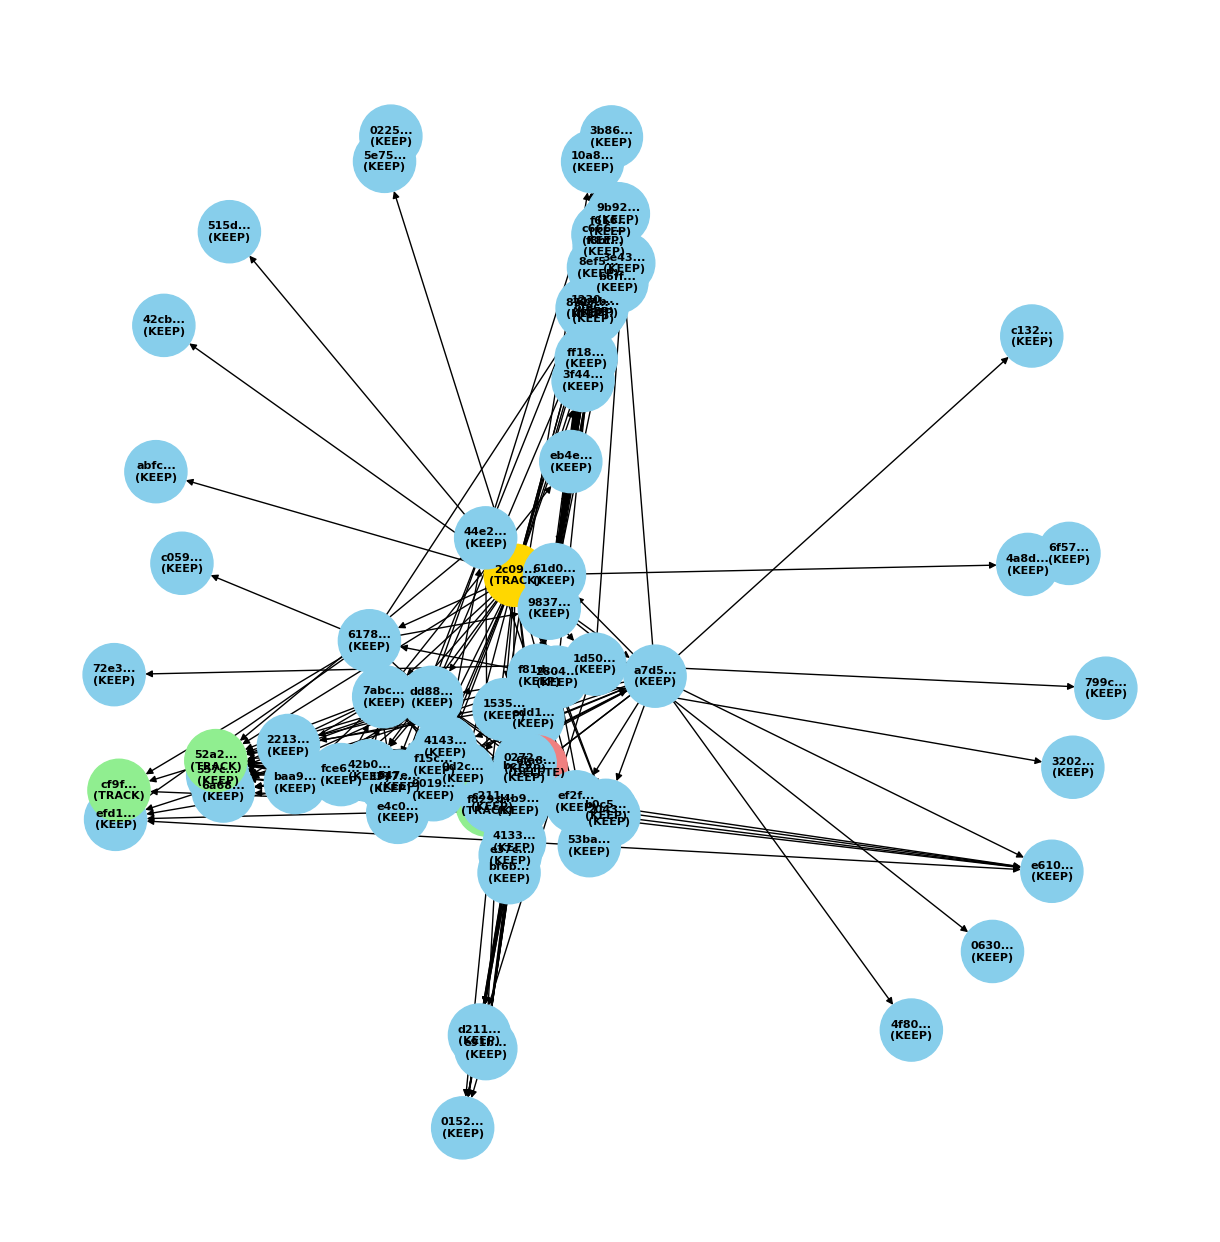

In [10]:
# --- Cell 4: Visualize the Graph ---
graph = manager.graph
if graph and graph.nodes():
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(graph, seed=42)
    
    labels = {node_id: f"{data['segment'].id[:4]}...\n({data['segment'].tag})" for node_id, data in graph.nodes(data=True)}
    
    color_map = {'KEEP': 'skyblue', 'TRACK': 'lightgreen', 'DELETE': 'lightcoral'}
    if manager.root_id in graph.nodes:
        graph.nodes[manager.root_id]['segment'].tag = 'ROOT'
        color_map['ROOT'] = 'gold'
        
    node_colors = [color_map.get(data['segment'].tag, 'gray') for _, data in graph.nodes(data=True)]

    nx.draw(graph, pos, labels=labels, with_labels=True, node_size=2000, node_color=node_colors, font_size=8, font_weight='bold')
    plt.title('Knowledge Graph from PartitionManager')
    plt.show()
else:
    print("No graph data to visualize.")

In [ ]:
# --- Cell 5: Print Deleted Segments ---
print("--- Segments Marked for Deletion ---")
deleted_segments = [seg for seg in manager.segments.values() if seg.tag == 'DELETE']

if deleted_segments:
    for i, segment in enumerate(deleted_segments):
        print(f"--- Deleted Segment {i+1} (ID: {segment.id}) ---")
        print(segment.content)
        print("-" * 40)
else:
    print("No segments were marked for deletion.")

--- Segments Marked for Deletion ---
--- Deleted Segment 1 (ID: 6fa80fd7-79a0-4a6e-b4d6-b1234e3c340a) ---
**Attention head manipulation** through instructional seeding

The key insights from the document:

## Graph-Theoretic Foundation
- Your partitions would have **15-30% overlap** to hit the percolation threshold
- This creates both **local coherence** and **global connectivity**
- Small-world network properties emerge naturally

## Practical Implementation
The most actionable approach seems to be:
1. **Seed instructions** throughout text (like `<MATH>`, `<DIALOGUE>`, `<TRACK>`)
2. Use **attention patterns** to recover/reinforce these partitions
3. Let the **LLM classify chunks** as KEEP/DELETE/TRACK
4. Build a **graph structure** where edges represent semantic relationships

## The "Fuzzy Pipeline"
Your system would essentially create:
- **Working memory** (active context)
- **Archive memory** (kept chunks)
- **Pending threads** (tracked items)
- All connected via a percolation-enab

: 